In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas_ta as ta
import yfinance as yf 
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

In [2]:
df = pd.read_csv('2022.2.9BTCUSDT-H1-NoSession.csv')
df.Date = df.Date.astype(str)+' '+ df.Time
df.Date = pd.to_datetime(df.Date)
df.drop(columns= ['Time'], inplace = True)
df = df.set_index('Date')

In [3]:
#initial
def set_up_df(df:pd.DataFrame , index):  
    df1    =   pd.DataFrame(columns=index)
    df1['date']  =    df.index 
    df1.date = pd.to_datetime(df1.date,format='%Y-%m-%d')
    df1 = df1.set_index('date')
    return df1

#for calculate duration
def convert_to_hours(delta):
    total_seconds = delta.total_seconds()
    hours = str(int(total_seconds // 3600))
    return hours

#Performance Matric
def cal_consecutive(df:pd.DataFrame):
    df['win']= np.sign(df) # assign sign on log
    blocks = df['win'].ne(df['win'].shift()).cumsum() 
    df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
    return df['consecutive_WL'] 

def Cal_portstat(port):
    port_return = port.total_return().to_frame()
    port_return['MaxDD'] = port.max_drawdown()
    port_return['NumTrade'] = port.trades.count()
    port_return['WinRate'] = port.trades.win_rate()
    port_return['AvgWinningTrade'] = port.trades.winning.returns.mean()
    port_return['AvgLosingTrade'] = port.trades.losing.returns.mean()
    port_return['SharpRatio'] = port.returns_acc.sharpe_ratio()
    return port_return

def Cal_pip(df):
    pip = []
    pipp = df['Avg Exit Price'] - df['Avg Entry Price']
    for i in portfinal['Direction']:
        if i == 'Long':
            pip.append(1)
        else :
            pip.append(-1)    
    return (pip * pipp) 

def Cal_mae_mfe(data,port):
    MAE = []
    MFE = []
    for i,j,y,k in zip(port['Entry Timestamp'], port['Exit Timestamp'], port['Avg Entry Price'], port['Direction']):
        if k == 'Long':
            MFE.append((data.loc[i:j]['High'].max() - y)/y)
            MAE.append((y - df.loc[i:j]['Low'].min())/y)
        else :
            MAE.append((data.loc[i:j]['High'].max() - y)/y)
            MFE.append((y - df.loc[i:j]['Low'].min())/y)
    return MAE, MFE  

def Calkelly(port):
    init_cash = 10000
    W = port.stats()[15]/100
    A = abs(port.stats()[19])
    B = port.stats()[18]
    Percent_kelly = (W/A) - ((1-W)/B)
    riskpertrade = Percent_kelly * init_cash
    print(f'Percent_kelly = {Percent_kelly}')

### Final

In [4]:
df['atr'] = df.ta.atr()

In [5]:
multiply = 3
df['sl_stop'] = (df['atr'] * multiply) / df.Close
riskpertrade = 2800
size = (riskpertrade/df['sl_stop'])/ df.Close

In [6]:
roc1 = df.ta.roc(20) #fast 
roc2 = df.ta.roc(40) #slow

l_1 = roc1.vbt.crossed_above(0)
l_2 =  roc2 > 0  
long_signal = (l_1  & l_2 )
        
s_1 = roc1.vbt.crossed_below(0)
s_2 =  roc2 < 0  
short_signal = (s_1  & s_2 )
        
long_exit =  s_1& s_2
short_exit = l_1& l_2

LongEntries = long_signal
LongExit= long_exit    
ShortEntries= short_signal
ShortExit= short_exit

port = vbt.Portfolio.from_signals(df.Close,
                                    entries = LongEntries,
                                    exits = LongExit,
                                    short_entries = ShortEntries,
                                    short_exits = ShortExit,
                                    freq = 'H',
                                    init_cash = 100000,
                                    fees = 0.00,
                                    slippage = 0.00, size = size
                                    ,sl_stop = df['sl_stop']
                                     )

In [7]:
Calkelly(port)

Percent_kelly = 0.041970223223554176


In [8]:
port.stats()

Start                               2017-08-17 04:00:00
End                                 2022-02-03 00:00:00
Period                               1625 days 15:00:00
Start Value                                    100000.0
End Value                                 713308.962885
Total Return [%]                             613.308963
Benchmark Return [%]                         755.879438
Max Gross Exposure [%]                    202416.275203
Total Fees Paid                                     0.0
Max Drawdown [%]                              22.218817
Max Drawdown Duration                 176 days 19:00:00
Total Trades                                        713
Total Closed Trades                                 712
Total Open Trades                                     1
Open Trade PnL                               -59.867605
Win Rate [%]                                  32.724719
Best Trade [%]                                37.265715
Worst Trade [%]                              -15

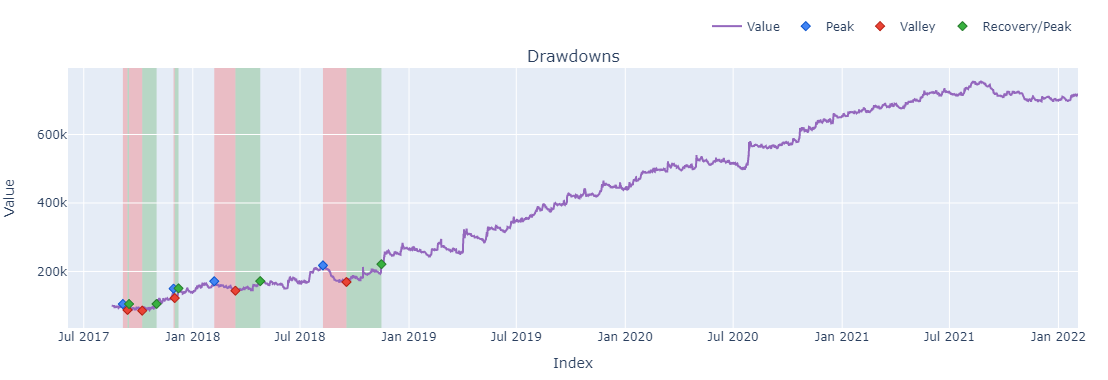

In [9]:
port.plot(subplots=['drawdowns']).show()

In [21]:
portfinal = port.trades.records_readable
portfinal['PnL_pip'] = Cal_pip(portfinal)

In [22]:
portfinal.head()

Exit Trade Id  Column       Size     Entry Timestamp  Avg Entry Price  \
0              0       0  15.668120 2017-08-21 09:00:00          4074.00   
1              1       0  11.838248 2017-08-23 22:00:00          4114.20   
2              2       0  17.511170 2017-08-27 03:00:00          4314.91   
3              3       0  18.890402 2017-08-27 17:00:00          4340.00   
4              4       0  13.395268 2017-08-28 13:00:00          4347.00   

   Entry Fees      Exit Timestamp  Avg Exit Price  Exit Fees          PnL  \
0         0.0 2017-08-22 00:00:00         3790.00        0.0 -4449.746136   
1         0.0 2017-08-27 03:00:00         4314.91        0.0  2376.054716   
2         0.0 2017-08-27 17:00:00         4340.00        0.0  -439.355261   
3         0.0 2017-08-28 05:00:00         4169.01        0.0 -3230.069889   
4         0.0 2017-09-02 05:00:00         4473.35        0.0  1692.492099   

     Return Direction  Status  Position Id  PnL_pip  
0 -0.069710      Long  Closed            0  -284.00  
1  0.048785      Long  Closed            1   200.71  
2 -0.005815     Short  Closed            2   -25.09  
3 -0.039399      Long  Closed            3  -170.99  
4  0.029066      Long  Closed            4   126.35

In [23]:
Rmultiple = portfinal.PnL /abs(portfinal[portfinal['PnL']<0]['PnL'].mean())
Rexpectancy= Rmultiple.mean()
SQN = (Rexpectancy/Rmultiple.std())*(len(Rmultiple)**0.5)
print(f'SQN = {SQN}')

SQN = 3.3736935871317506


In [24]:
consecutive = cal_consecutive(portfinal['PnL'])
abs(consecutive[consecutive<0]).value_counts()

1.0     161
2.0     109
3.0      70
4.0      42
5.0      27
6.0      19
7.0      15
8.0      10
9.0       9
10.0      6
11.0      4
12.0      1
13.0      1
14.0      1
15.0      1
16.0      1
17.0      1
18.0      1
19.0      1
Name: PnL, dtype: int64

<AxesSubplot:xlabel='PnL', ylabel='Density'>

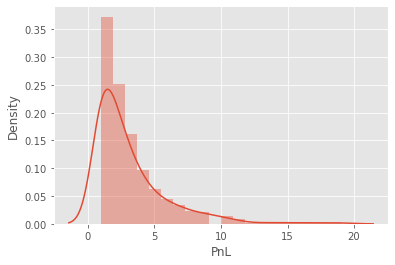

In [25]:
sns.distplot(abs(consecutive[consecutive<0]), bins=20)

In [26]:
print(f"Consecutive loss = {np.abs(cal_consecutive(portfinal['PnL']).min())}")
print(f"Consecutive win = {np.abs(cal_consecutive(portfinal['PnL']).max())}")

Consecutive loss = 19.0
Consecutive win = 6.0


In [27]:
Holding_period = (portfinal['Exit Timestamp'] - portfinal['Entry Timestamp']).apply(convert_to_hours).astype('int')

In [28]:
Holding_period.describe()

count    713.000000
mean      46.206171
std       48.900649
min        1.000000
25%       12.000000
50%       26.000000
75%       68.000000
max      297.000000
dtype: float64

In [29]:
tradingdata = df.reset_index()
tradingdata = tradingdata[['Date', 'Open', 'High', 'Low', 'Close']]

In [30]:
tradingdata['_normPrice'] = (tradingdata.Close-tradingdata.Low)/(tradingdata.High-tradingdata.Low)

In [31]:
tradingdata['_slope3'] = tradingdata.ta.slope(3)
tradingdata['_slope5'] = tradingdata.ta.slope(5)
tradingdata['_slope10'] = tradingdata.ta.slope(10)
tradingdata['_slope20'] = tradingdata.ta.slope(20)

In [32]:
tradingdata['_BBwid'] = tradingdata.ta.bbands()['BBU_5_2.0'] - tradingdata.ta.bbands()['BBL_5_2.0']

In [33]:
# MACD
tradingdata[['_macd','_hist','_sig']]= ta.macd(tradingdata['Close'])
tradingdata.drop(columns = '_sig',inplace = True)

In [34]:
# ADX
tradingdata['_adx'] = ta.adx(tradingdata['High'],tradingdata['Low'],tradingdata['Close']).iloc[:,:1]

In [35]:
# Slope
tradingdata['_slope50'] = ta.slope(tradingdata['Close'], 50)

In [36]:
# CCI
tradingdata['_cci'] = ta.cci(tradingdata['High'], tradingdata['Low'], tradingdata['Close'])

In [37]:
# RSI
tradingdata['_rsi'] = ta.rsi(tradingdata['Close'])

In [38]:
# Stoch
tradingdata['_stochK'] = ta.stoch(tradingdata['High'], tradingdata['Low'], tradingdata['Close']).iloc[:,:1]

In [39]:
# NATR
tradingdata['_natr'] = ta.natr(tradingdata['High'], tradingdata['Low'], tradingdata['Close'])

In [40]:
# Stdev
tradingdata['_stdev'] = ta.stdev(tradingdata['Close'])

In [41]:
tradingdata['_truerange'] =  ta.true_range(tradingdata['High'], tradingdata['Low'], tradingdata['Close'])

#### merge with portfinal

In [42]:
full_position_data = tradingdata.merge(portfinal, left_on = 'Date', right_on = 'Entry Timestamp')
full_position_data.dropna(inplace = True)

In [43]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler
# these classifiers contain either coef_ or feature_importances_ attribute.
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score

In [44]:
full_position_data['target'] = np.where(full_position_data['Return'] > 0, 1, 0)

##### only long position

In [45]:
full_position_data = full_position_data[full_position_data['Direction'] == 'Long']

In [46]:
# class count
class_count_0, class_count_1 = full_position_data['target'].value_counts()

class_0 = full_position_data[full_position_data['target'] == 0]
class_1 = full_position_data[full_position_data['target'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (237, 37)
class 1: (123, 37)


In [47]:
class_1_sample = class_1.sample(123)
class_0_sample = class_0.sample(123)
mldata = pd.concat([class_1_sample, class_0_sample], axis=0)

In [48]:
mldata['target'].value_counts()

1    123
0    123
Name: target, dtype: int64

In [49]:
cols=['_normPrice','_slope3','_slope5','_slope10','_slope20','_BBwid','_macd', '_hist', '_adx', '_slope50', '_cci', '_rsi',
       '_stochK', '_natr', '_stdev', '_truerange']
X = mldata[cols]
y = mldata['target']

In [50]:
test_size=.2
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=test_size
                                                    ,random_state=7)

In [51]:
rf1 = GradientBoostingClassifier(random_state=42)
rf1.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
trainscore = rf1.score(X_train, y_train)
testscore = rf1.score(X_test, y_test)
y_pred=rf1.predict(X_test)

print(f'Train data score: {trainscore:.04f}')
print(f'Test data score: {testscore:.04f}')
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))

### Feature importance by Randomforest

In [ ]:
fs=pd.Series(rf1.feature_importances_, index=cols).sort_values(ascending=True)
fs

In [ ]:
fs.plot(kind = 'barh')

### shap explainer and feature impact

In [ ]:
import shap
explainer = shap.TreeExplainer(rf1)
shap_values = np.array(explainer.shap_values(X_train))
print(shap_values.shape)

2 : number of classes. 
92 : number of datapoints. We have local SHAP values per datapoint.
12 : number of features. We have SHAP value per every feature.

In [ ]:
shap.summary_plot(shap_values[1], X_train, plot_type="bar",feature_names = cols)

In [ ]:
shap.summary_plot(shap_values[1], X_train,feature_names = cols)

<AxesSubplot:xlabel='target', ylabel='_stdev'>

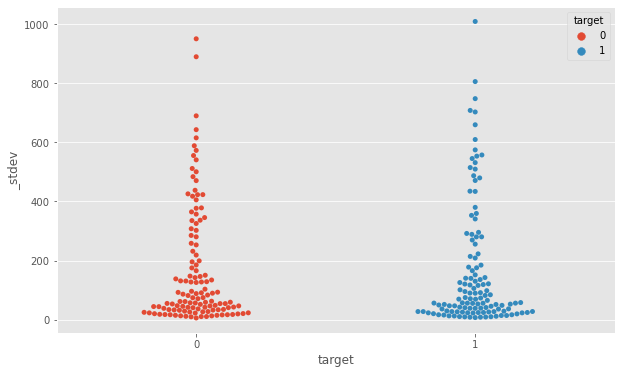

In [52]:
plt.figure(figsize=(10, 6))
sns.swarmplot(mldata.target, mldata._stdev, hue = mldata.target)

<AxesSubplot:xlabel='target', ylabel='_normPrice'>

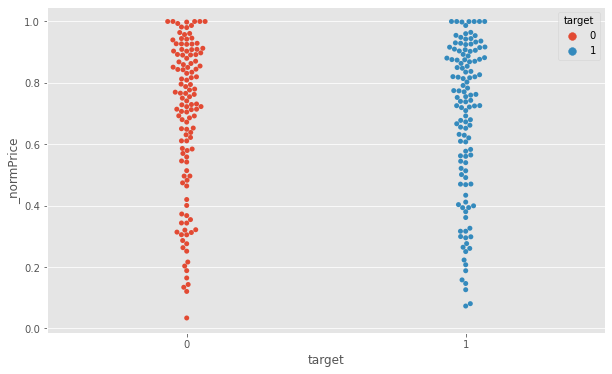

In [53]:
plt.figure(figsize=(10, 6))
sns.swarmplot(mldata.target, mldata._normPrice, hue = mldata.target)

In [54]:
import pingouin as pg

In [55]:
for i in cols:
    a = mldata[mldata.target ==1][i].reset_index(drop=True)
    b = mldata[mldata.target ==0][i].reset_index(drop=True)
    print(i)
    print(pg.ttest(a, b).iloc[:,:7])

_normPrice
               T  dof alternative     p-val          CI95%   cohen-d  BF10
T-test -0.097808  244   two-sided  0.922165  [-0.07, 0.06]  0.012472  0.14
_slope3
               T  dof alternative     p-val            CI95%   cohen-d   BF10
T-test  0.503718  244   two-sided  0.614914  [-27.05, 45.64]  0.064232  0.157
_slope5
               T  dof alternative     p-val            CI95%   cohen-d   BF10
T-test  0.133041  244   two-sided  0.894271  [-20.66, 23.66]  0.016965  0.141
_slope10
               T  dof alternative     p-val           CI95%   cohen-d   BF10
T-test  0.236133  244   two-sided  0.813528  [-9.06, 11.53]  0.030111  0.143
_slope20
               T  dof alternative     p-val          CI95%   cohen-d   BF10
T-test  0.634024  244   two-sided  0.526659  [-1.71, 3.34]  0.080848  0.169
_BBwid
               T  dof alternative     p-val             CI95%   cohen-d   BF10
T-test  0.717336  244   two-sided  0.473853  [-109.02, 233.9]  0.091471  0.178
_macd
               T